# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
def import_tensorflow():
    """
    Import tensorflow and disable all warnings.
    
    Copy and paste from
    https://weepingfish.github.io/2020/07/22/0722-suppress-tensorflow-warnings/
    """
    # Filter tensorflow version warnings
    import os
    # https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
    import warnings
    # https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    import tensorflow as tf
    tf.get_logger().setLevel('INFO')
    tf.autograph.set_verbosity(0)
    import logging
    tf.get_logger().setLevel(logging.ERROR)
    return tf

In [2]:
# Make all necessary imports.
%matplotlib inline

tf = import_tensorflow()
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import models
import plotting
import utils

# keep this line during development to reload the utils module without restarting the kernel
import importlib
importlib.reload(utils)
importlib.reload(models)
importlib.reload(plotting)

<module 'plotting' from '/work/plotting.py'>

In [3]:
# print information about librariers and GPU resources available
print(f"tensorflow version: {tf.__version__}")
print(f"tensorflow_datasets version: {tfds.__version__}")
print(f"tensorflow_hub version: {hub.__version__}")
print(f"GPU available: {tf.test.is_gpu_available()}")

tensorflow version: 2.15.0
tensorflow_datasets version: 4.8.0
tensorflow_hub version: 0.15.0
GPU available: True


In [4]:
# set GPU to NOT allocate all memory on the device
# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# https://www.tensorflow.org/datasets/catalog/oxford_flowers102

splits = ["train", "validation", "test"]
dataset, dataset_info = tfds.load("oxford_flowers102", as_supervised=True, with_info=True, split=splits)
train_set, validation_set, test_set = dataset

In [6]:
# display information on the dataset
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [7]:
# Print information on the datasets

# NOTE: this breakdown differs significantly from another Udacity project in which you implement
#       a similar classifier (using PyTorch).  That project has 6552 training, 819 validation, 
#       819 test.  I will use the breakdown provided by the tensorflow_dataset, but am noting 
#       this for future reference.
#
#       See https://github.com/mrperkett/udacity-project-create-image-classifier
#       for my PyTorch project.

# display information for dataset split
print(f"train_set num images: {len(train_set)}")
print(f"validation_set num images: {len(validation_set)}")
print(f"test_set num images: {len(test_set)}")


# display information on number of classes and their labels
class_idx_to_class_name, class_name_to_class_idx = utils.get_class_idx_and_name_mappings(dataset_info)
print(f"num classes: {len(class_idx_to_class_name)}")

# display some example mappings
print(f"\nExample class_idx_to_class_name mappings")
print("class_idx    class_name")
for n, (class_idx, class_name) in enumerate(class_idx_to_class_name.items()):
    if n == 5:
        break
    print(f"{str(class_idx).ljust(13)}{class_name}")

train_set num images: 1020
validation_set num images: 1020
test_set num images: 6149
num classes: 102

Example class_idx_to_class_name mappings
class_idx    class_name
0            pink primrose
1            hard-leaved pocket orchid
2            canterbury bells
3            sweet pea
4            english marigold


In [8]:
# Print the shape and corresponding label of 3 images in the training set.
gen = iter(train_set.take(3))
for n in range(3):
    image, class_idx = next(gen)
    class_idx = class_idx.numpy()
    class_name = class_idx_to_class_name[class_idx]
    print(f"Image {n}")
    print(f"\tlabel: {class_idx}")
    print(f"\tclass_name: {class_name}")
    print(f"\timage dimensions: {image.shape}")

Image 0
	label: 72
	class_name: water lily
	image dimensions: (500, 667, 3)
Image 1
	label: 84
	class_name: desert-rose
	image dimensions: (500, 666, 3)
Image 2
	label: 70
	class_name: gazania
	image dimensions: (670, 500, 3)


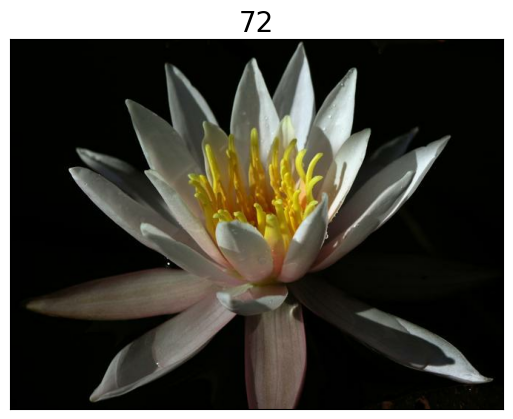

In [9]:
# Plot one image from the training set setting the title as its
# corresponding label (i.e. class_idx)
from plotting import plot_image
image, class_idx = next(iter(train_set.take(1)))
class_idx = class_idx.numpy()
title = f"{class_idx}"
ax = plot_image(image, title=title)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
# load class_idx and class_name mappings from json input file
# NOTE: using the json label mapping file is unnecessary given that you can 
#       collect this information from dataset_info.  For the purposes of this
#       project, I will proceed as if this file is needed.
json_file_path = "label_map.json"
_class_idx_to_class_name, _class_name_to_class_idx = \
        utils.get_class_idx_and_name_mappings_from_json(json_file_path)

In [11]:
# quick check to verify that the loaded mapping dicts from the json file match
# the mapping dicts derived from dataset_info
s1 = {(k, v) for k, v in class_idx_to_class_name.items()}
s2 = {(k, v) for k, v in _class_idx_to_class_name.items()}
if s1 == s2:
    print(f"class_idx_to_class_name dictionaries are equivalent!")
else:
    raise AssertionError(f"class_idx_to_class_name is not equivalent to _class_idx_to_class_name")

s1 = {(k, v) for k, v in class_name_to_class_idx.items()}
s2 = {(k, v) for k, v in _class_name_to_class_idx.items()}
if s1 == s2:
    print(f"class_name_to_class_idx dictionaries are equivalent!")
else:
    raise AssertionError(f"class_name_to_class_idx is not equivalent to _class_name_to_class_idx")

class_idx_to_class_name dictionaries are equivalent!
class_name_to_class_idx dictionaries are equivalent!


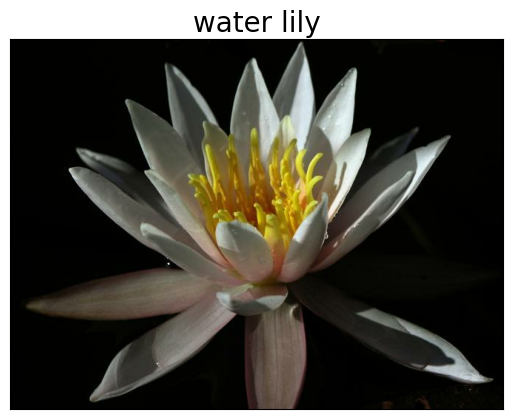

In [12]:
# Plot one image from the training set setting the title as its
# corresponding name (i.e. class_name)
from plotting import plot_image

image, class_idx = next(iter(train_set.take(1)))
class_idx = class_idx.numpy()
class_name = class_idx_to_class_name[class_idx]
title = f"{class_name}"
ax = plot_image(image, title=title)

## Create Pipeline

NOTE: the `augment_images` and `preprocess_images` functions are defined in `utils.py`, but have been copied and pasted below for convenience.

```python
# define image augmentation and preprocessing layers outside of the function as
# is required by tensorflow variable Singelton pattern
# https://www.tensorflow.org/guide/function#creating_tfvariables
img_height = 224
img_width = 224
image_augmentation_layers = [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomZoom(0.2, 0.2, fill_mode="nearest"),
        tf.keras.layers.RandomRotation([-1./12, 1./12])
        ]

image_preprocessing_layers = [
        tf.keras.layers.Resizing(height=256, width=256, crop_to_aspect_ratio=True),
        tf.keras.layers.CenterCrop(height=img_height, width=img_width),
        tf.keras.layers.Rescaling(1./255)
        ]

def augment_images(images):
    """
    Augment images during training to maintain generalizability.
    """
    for layer in image_augmentation_layers:
        images = layer(images)
    return images


def preprocess_images(images):
    """
    Image preprocessing (both during training and for inference)
    """
    for layer in image_preprocessing_layers:
        images = layer(images)
    return images
```

In [13]:
from utils import augment_images, preprocess_images
img_height, img_width, img_num_channels = 224, 224, 3

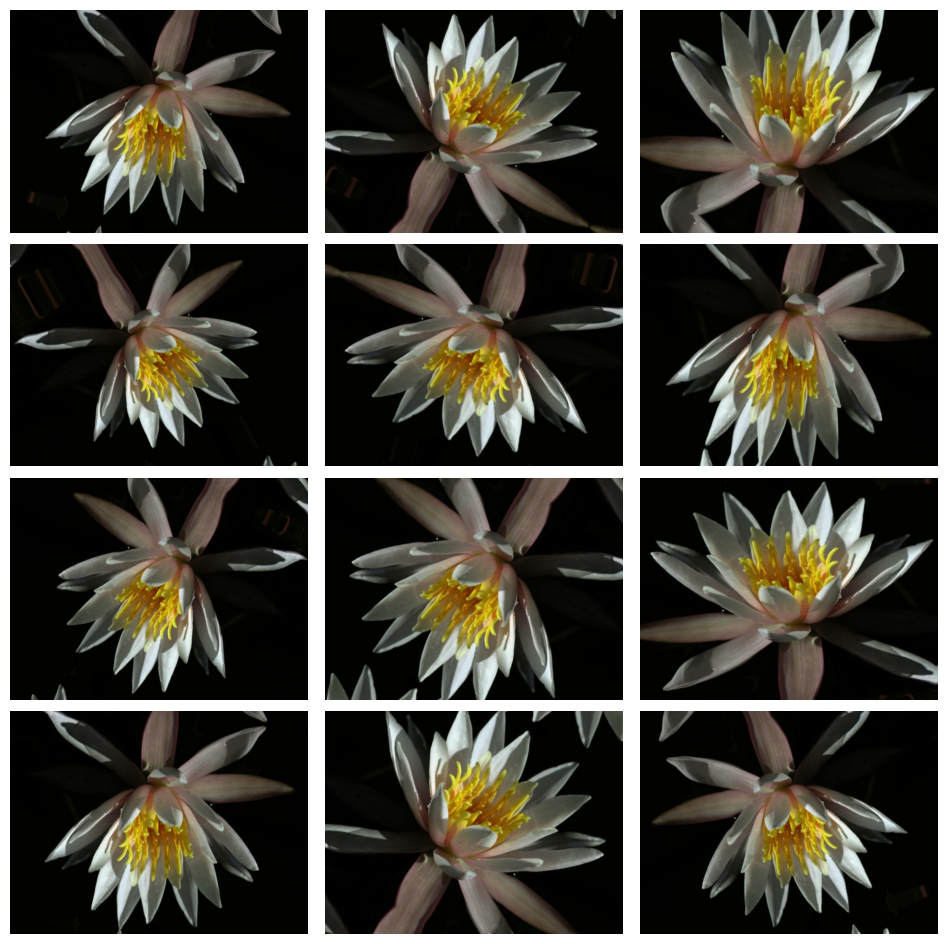

In [14]:
# plot some of the augmented images to ensure they look reasonable
from plotting import plot_grid_augmented_images
images, _ = next(iter(train_set.take(1)))
plot_grid_augmented_images(images, augment_images, n_rows=4, n_columns=3)

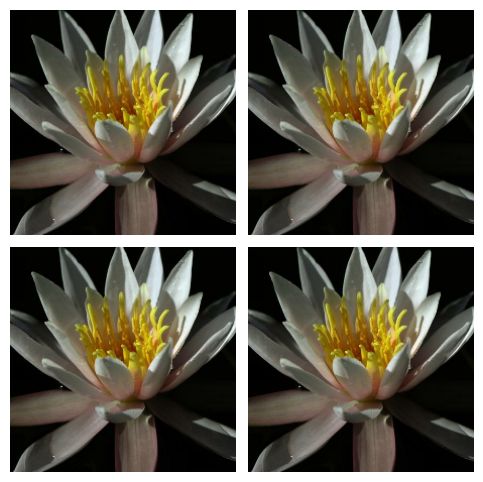

In [15]:
# Plot some of the preprocessed images to ensure they look reasonable.  Note
# how they are now have equal aspect ratio and have been center cropped.
images, _ = next(iter(train_set.take(1)))
plot_grid_augmented_images(images, preprocess_images, n_rows=2, n_columns=2, rescale_factor=255.)

In [16]:
importlib.reload(utils)
from utils import augment_images, preprocess_images
# Create the training, validation, and testing batches. 

# I include all data augmentation and image preprocessing as part of the DataSet
# batching process. I have chosen to do this since images within the same batch 
# must be the same shape during training and this dataset has images of different
# sizes.  I will add the image preprocessing steps back in to the final model that
# is saved for better portability.
# See the following link for a discussion of where to place the image preprocessing
# steps:
# https://www.tensorflow.org/guide/keras/preprocessing_layers

batch_size = 32
num_training_samples = len(train_set)

img_augment_func = lambda img, label: (augment_images(img), label)
img_preprocess_func = lambda img, label: (preprocess_images(img), label)

training_batches = train_set.cache().shuffle(num_training_samples//4).map(img_preprocess_func).batch(batch_size).map(img_augment_func).prefetch(1)
validation_batches = validation_set.cache().map(img_preprocess_func).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(img_preprocess_func).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

# Notes from model definitions

I ran into issues when I first attempted to save / load keras SavedModels that were loaded with the `tensorflow_hub` `load` function.  Everything would work fine until I went to load the model.  For this project, I've found it easier to use the models defined in `tf.keras.applications`, but I am documenting what I've learned below for future reference.

## Links
- https://www.tensorflow.org/hub/tf2_saved_model
 - https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb
 - https://stackoverflow.com/questions/63146892/how-to-load-a-keras-model-saved-as-pb/63147104#63147104
 - https://www.tensorflow.org/guide/saved_model
 - https://www.tensorflow.org/guide/checkpoint


## Example
This is an example of code that works to save / load the model.  Note that it saves and loads from a directory.  Read through the links above for more information.

```python
loaded_obj = hub.load("https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1")
mobile = hub.KerasLayer(loaded_obj, trainable=False)

model = tf.keras.Sequential()
model.add(mobile)
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.build([None, 224, 224, 3])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 1
history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)


tf.saved_model.save(model, "temp")

loaded_obj = tf.saved_model.load("temp")
loaded_model = tf.keras.Sequential([hub.KerasLayer(loaded_obj)])
loaded_model.build([None, 224, 224, 3])
loaded_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```

In [27]:
# model definitions
# See the following for a similar example
# https://keras.io/examples/vision/image_classification_from_scratch/

num_classes = len(class_idx_to_class_name)
model = models.make_model(num_classes=num_classes)
model.build([None, img_height, img_width, img_num_channels])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 1000)              5507432   
 al)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_11 (Dense)            (None, 102)               102102    
                                                                 
Total params: 5609534 (21.40 MB)
Trainable params: 102102 (398.84 KB)
Non-trainable params: 5507432 (21.01 MB)
_________________________________________________________________


In [28]:
# train model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

num_epochs = 10
history = model.fit(training_batches,
                    epochs=num_epochs,
                    validation_data=validation_batches)

Epoch 1/10
32/32 [==============================] - 13s 277ms/step - loss: 5.3525 - accuracy: 0.0461 - val_loss: 3.3089 - val_accuracy: 0.2549
Epoch 2/10
32/32 [==============================] - 7s 231ms/step - loss: 2.9674 - accuracy: 0.2882 - val_loss: 2.1016 - val_accuracy: 0.5137
Epoch 3/10
32/32 [==============================] - 7s 229ms/step - loss: 1.9925 - accuracy: 0.5029 - val_loss: 1.6164 - val_accuracy: 0.6176
Epoch 4/10
32/32 [==============================] - 7s 230ms/step - loss: 1.3858 - accuracy: 0.6539 - val_loss: 1.3111 - val_accuracy: 0.6765
Epoch 5/10
32/32 [==============================] - 7s 229ms/step - loss: 1.2132 - accuracy: 0.6843 - val_loss: 1.1479 - val_accuracy: 0.7147
Epoch 6/10
32/32 [==============================] - 7s 229ms/step - loss: 0.9682 - accuracy: 0.7431 - val_loss: 1.0558 - val_accuracy: 0.7304
Epoch 7/10
32/32 [==============================] - 7s 231ms/step - loss: 0.7863 - accuracy: 0.7961 - val_loss: 0.9596 - val_accuracy: 0.7755
Epoch

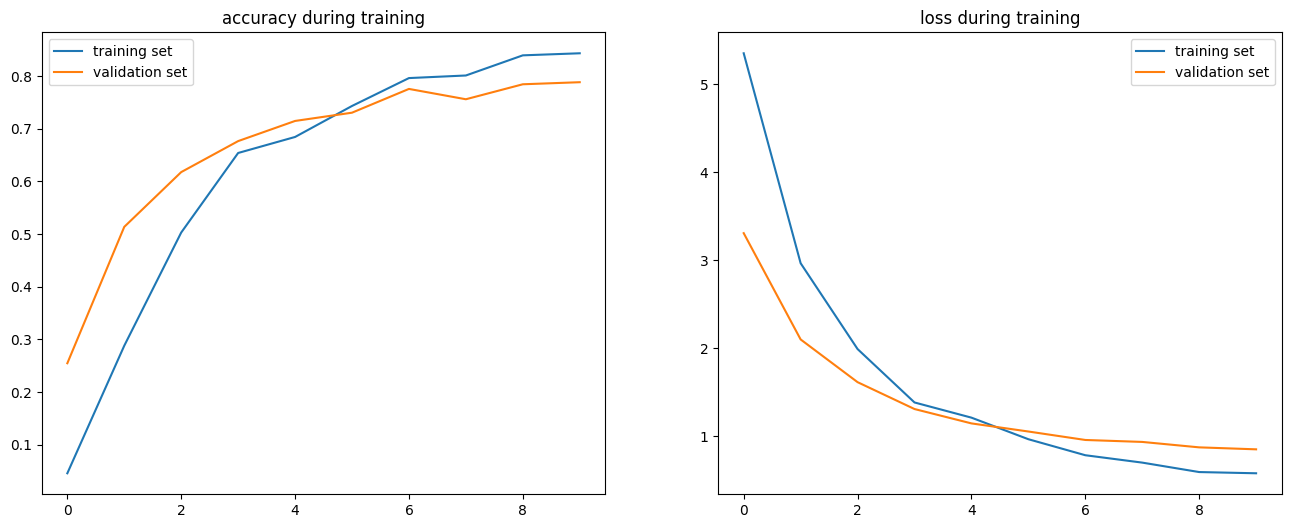

In [40]:
# plot the loss and accuracy values achieved during training for 
# the training and validation sets.
from plotting import plot_training_metrics
ax = plot_training_metrics(history)

plt.savefig(os.path.join("output", "training-performance.png"), dpi=300)

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [30]:
# print the loss and accuracy values achieved on the entire test set.
testing_loss, testing_accuracy = model.evaluate(testing_batches)

print(f"testing loss: {testing_loss}")
print(f"testing accuracy: {testing_accuracy}")

193/193 [==============================] - 10s 52ms/step - loss: 1.0084 - accuracy: 0.7479
testing loss: 1.0083515644073486
testing accuracy: 0.7479264736175537


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [31]:
# save the trained model in the Keras v3 format
saved_model_file_path = "saved_model.keras"
model.save(saved_model_file_path)

In [32]:
# show the files contained within the saved model
!unzip -t {saved_model_file_path}

Archive:  saved_model.keras
    testing: metadata.json            OK
    testing: config.json              OK
    testing: model.weights.h5         OK
No errors detected in compressed data of saved_model.keras.


## Load the Keras Model

Load the Keras model you saved above.

In [33]:
reloaded_model = tf.keras.models.load_model(saved_model_file_path)

# print the loss and accuracy values achieved on the entire test set.
reloaded_testing_loss, reloaded_testing_accuracy = reloaded_model.evaluate(testing_batches)

print(f"testing loss: {reloaded_testing_loss}")
print(f"testing accuracy: {reloaded_testing_accuracy}")

193/193 [==============================] - 11s 44ms/step - loss: 1.0084 - accuracy: 0.7479
testing loss: 1.0083515644073486
testing accuracy: 0.7479264736175537


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

img_arr.shape: (591, 500, 3)
img_arr.max(): 241
img_arr.min(): 0
processed_img_arr.shape: (224, 224, 3)
processed_img_arr.max(): 0.89631187915802
processed_img_arr.min(): 0.0


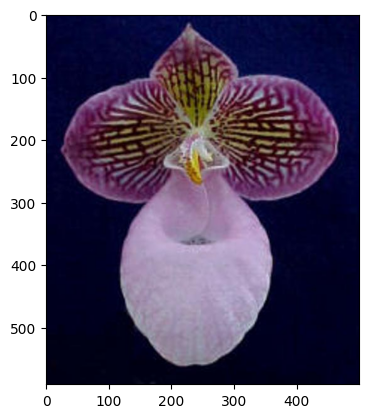

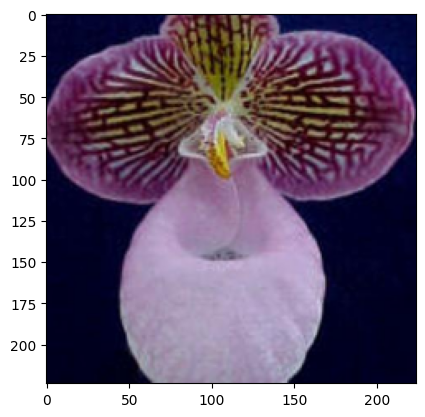

In [34]:
# Import the process_image function and demonstrate it is working as expected
from PIL import Image
importlib.reload(utils)
from utils import process_image

# load image into a numpy array of the expected shape
image_path = "./test_images/hard-leaved_pocket_orchid.jpg"
img = Image.open(image_path, "r")
img_arr = np.asarray(img)

# display unmodified image
fig, ax = plt.subplots()
ax.imshow(np.asarray(img))
print(f"img_arr.shape: {img_arr.shape}")
print(f"img_arr.max(): {img_arr.max()}")
print(f"img_arr.min(): {img_arr.min()}")

# process the image
processed_img_arr = process_image(img_arr)

# display the processed image
# NOTE: I have used a slightly different preprocessing method during training (resizing and
#       center cropping, and normalizing to range [0.0, 1.0]).  So the image below looks as
#       expected
fig, ax = plt.subplots()
ax.imshow(np.asarray(processed_img_arr))
print(f"processed_img_arr.shape: {processed_img_arr.shape}")
print(f"processed_img_arr.max(): {processed_img_arr.max()}")
print(f"processed_img_arr.min(): {processed_img_arr.min()}")

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

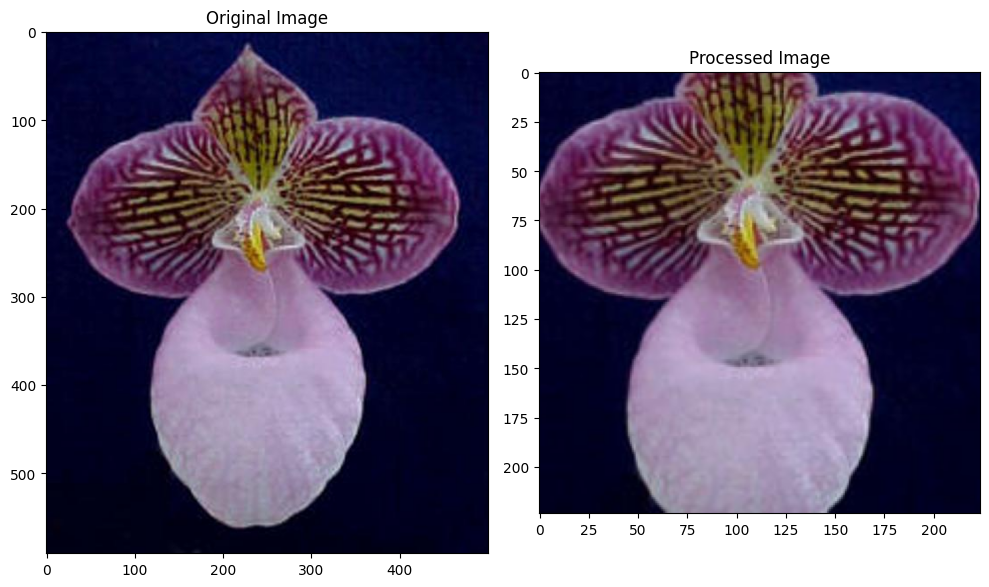

In [35]:
from PIL import Image

image_path = "./test_images/hard-leaved_pocket_orchid.jpg"
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [36]:
# import the predict function and demonstrate that it's working as expected
from utils import predict

image_path = "./test_images/hard-leaved_pocket_orchid.jpg"
probs, class_idxs = predict(image_path, model, top_k=5)

print("prob\tclass_idx\tclass_name")
for class_idx, prob in zip(class_idxs, probs):
    print(f"{prob:.4f}  {class_idx}  {class_idx_to_class_name[class_idx]}")

prob	class_idx	class_name
0.9979  1  hard-leaved pocket orchid
0.0019  79  anthurium
0.0000  22  fritillary
0.0000  0  pink primrose
0.0000  63  silverbush


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

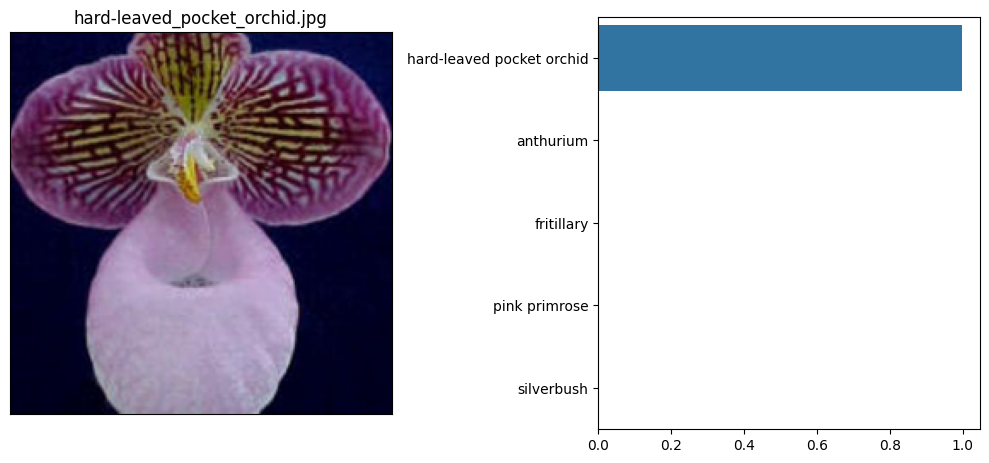

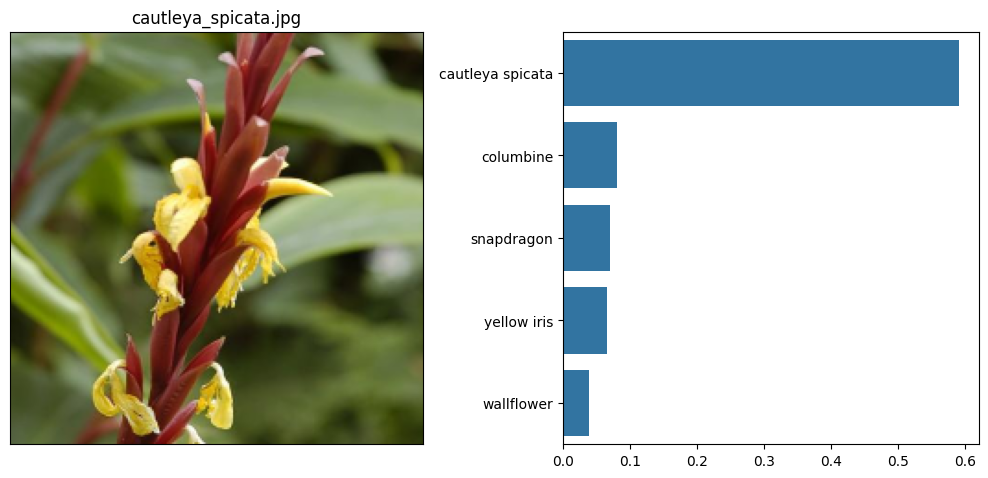

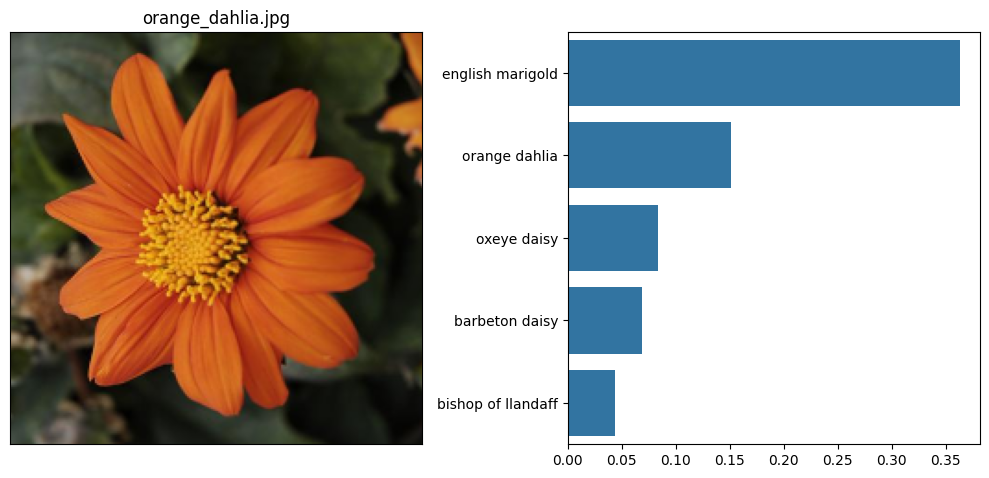

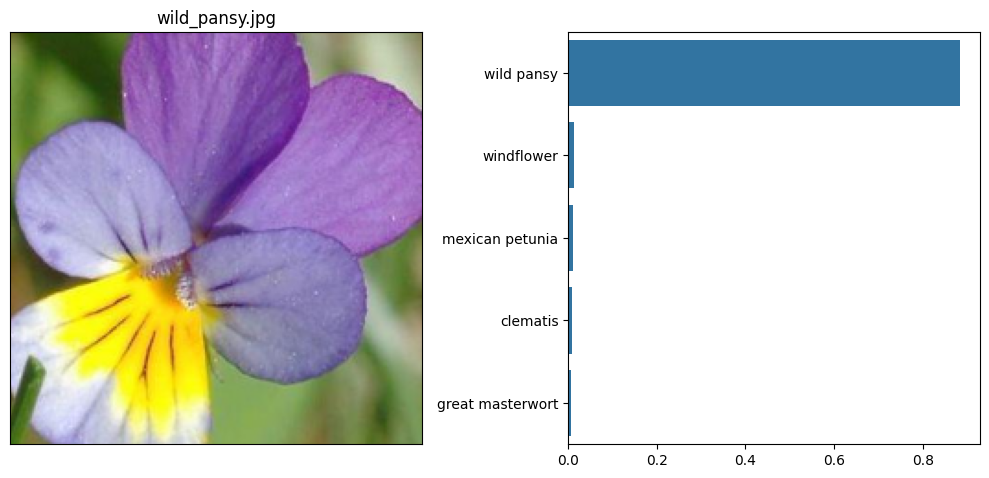

In [39]:
# plot the input image along with the top 5 classes for each of the test images
from plotting import plot_predictions

image_file_names = ["hard-leaved_pocket_orchid.jpg",
                    "cautleya_spicata.jpg",
                    "orange_dahlia.jpg",
                    "wild_pansy.jpg"]

for image_file_name in image_file_names:
    image_file_path = os.path.join("./test_images", image_file_name)
    ax = plot_predictions(image_file_path, model, class_idx_to_class_name, top_k=5)
    output_file_path = os.path.join("output", f"predictions-{image_file_name}")
    plt.savefig(output_file_path, dpi=300)